# Path Planning On a Grid :: Revisiting Dijkstra aka Dijkstra with the SearchNodes

<center><img src="./img/1.png"/></center>

In this lab, we will consider the problem of finding the shortest path on a graph with a special structure, widely used in robotics and computer games — a grid. The grid consists of both free and blocked cells, and an agent can move from one free cell to another. The connectivity of the grid may vary; for example, a grid might be 4-connected when only cardinal moves (N, E, W, S) are allowed, or 8-connected when diagonal moves are allowed as well.

**In this lab, we assume that the grid is 4-connected**, meaning that only moves into the cardinal directions (N, E, W, S) are allowed. The cost of each move between two neighboring cells, represented as $v$ and $v'$, is uniform, with $cost(v, v') = 1$.

We will explore the seminal `Dijkstra` algorithm for finding the shortest path on a grid. However, our focus is on implementing this algorithm as a "heuristic search without heuristic," utilizing the distinct `SearchNode` structure, along with concepts like `Open` and `Closed`.

*The more advanced algorithms we will be discussing in the next labs will build upon much of this implementation. Therefore, it's crucial to ensure that your code is both correct and efficient.*

Your task is to complete the missing code fragments as per the provided prompts and execute every cell in this notebook. All tests should pass successfully.

Let's get started!


<center><img src="./img/2.png"/></center>

In [1]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## Grid map representation 

In [2]:
from utils.Map import Map
from utils.utils import convert_string_to_cells

Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In the case of a 4-connected grid, the cost is always equal to 1. Consequently, the cost of each path is an integer.

However, please note that if the grid's connectivity exceeds 4, the cost of a transition may vary and may become fractional or even arbitrary (e.g., $\sqrt{2}$ for diagonal moves).

Recall that in this lab, we assume a 4-connected grid, meaning that only cardinal moves (up, down, left, right) are allowed, and as a result, all costs are integers.

In [3]:
from utils.utils import compute_cost

## Search Node

A Search node is a fundamental concept of a search algorithm. It encapsulates data about the state of the problem (e.g., the position of a robot on a grid) and the information needed to construct a search tree, including g-value, backpointer to its predecessor etc.


In [4]:
from utils.Node import Node

## Visualization

In [5]:
from utils.utils import draw

Example of the visualization

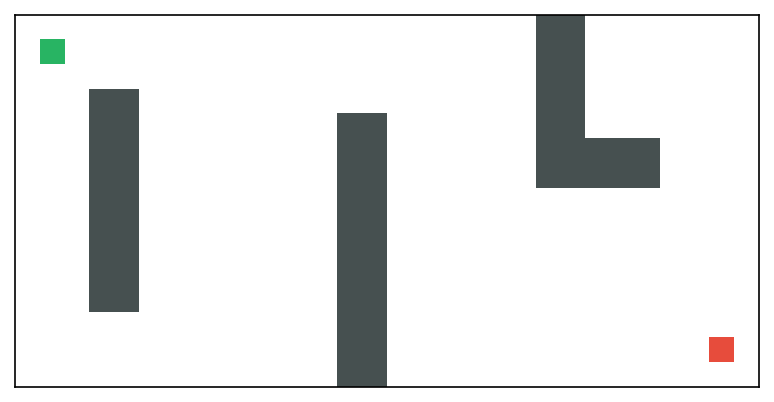

In [6]:
height = 15
width = 30
map_str = """
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
"""
cells = convert_string_to_cells(map_str)

test_map = Map(cells)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

## Implementing the Search Tree (i.e., OPEN and CLOSED)
An efficient implementation of the search tree (`OPEN` and `CLOSED`) is crucial for any search algorithm. Below, you'll find a basic implementation that uses lists to store the elements of `OPEN` and `CLOSED`. This method isn't very efficient, and you are tasked with creating your own implementations.

It's a good idea to start by modifying `CLOSED` since it's relatively straightforward. After making changes, ensure everything works OK—i.e., the search algorithms run faster and produce the right results. Following that, you can proceed to modify `OPEN`, which might be more challenging than it initially appears.

PS: Feel free to add additional fields, methods, method arguments, etc., to your implementations.


In [6]:
class SearchTreeL:
    """
    SearchTree that uses Lists for OPEN and CLOSED (NOT EFFICIENT).
    """

    def __init__(self):
        self._open = []  # List for the OPEN nodes
        self._closed = []  # List for the expanded nodes, i.e. CLOSED
        # No duplicates are present in a list-based implementation, so this always equals 0
        self._enc_open_duplicates = 0

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Typically, this is used to know
        the size of the search tree at the last iteration of the search,
        to assess the memory footprint of the algorithm.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Indicates whether OPEN is exhausted or not.
        If it is, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a (previously not expanded) node to the search tree (i.e., to OPEN).
        It can either be a totally new node (one we haven't encountered before)
        or a duplicate of a node that currently resides in OPEN.
        In this implementation, duplicates are detected upon addition. So,
        if the newly added node corresponds to the same state (has the same coordinates),
        we check if the g-value of the new node is better (lower) than the old one.
        If it is, we replace the old node with the new one (since it's better).
        Otherwise, we discard the new node.
        """
        for idx, node in enumerate(self._open):
            if (node.i, node.j) == (item.i, item.j):
                if item.g < node.g:
                    self._open[idx] = item
                return
        self._open.append(item)

    def get_best_node_from_open(self) -> Node:
        """
        Extracts the best node (i.e., the one with the minimal key
        = min f-value = min g-value (for Dijkstra)) from OPEN.
        This node will be further expanded in the main search loop.
        """
        if self.open_is_empty():
            raise Exception("OPEN is empty")
        best_idx = 0
        for idx, node in enumerate(self._open):
            if node.g < self._open[best_idx].g:
                best_idx = idx
        return self._open.pop(best_idx)

    def add_to_closed(self, item: Node):
        self._closed.append(item)

    def was_expanded(self, item: Node) -> bool:
        return any((node.i, node.j) == (item.i, item.j) for node in self._closed)
        pass

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

Next, you need to implement the search tree with the following features:
- A dictionary for CLOSED
- A priority queue for OPEN
- Lazy duplicate detection in OPEN

The last point implies that every time you generate a node that has not been previously expanded, you should simply add it to OPEN (i.e., add it to the priority queue where priority is determined by the `Node.__lt__` comparator). This approach may frequently lead to situations where the same node, possibly with a different $g$-value, is already in OPEN. To handle this, every time you extract the best node from OPEN, check if the node has been previously expanded. If the node has been expanded before, the current node is considered a 'bad duplicate' (a duplicate with a higher $g$-value) and should be discarded.

To monitor the number of OPEN duplicates encountered during the search, use `_enc_open_duplicates`. Increment this value by 1 every time you discard a 'bad duplicate'.

PS: Remember to handle the situation where only 'bad duplicates' remain in OPEN correctly.


In [8]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        if self.open_is_empty():
            raise Exception("OPEN is empty")
        while self._open:
            best_node = heappop(self._open)
            if (best_node.i, best_node.j) not in self._closed:
                return best_node
            else:
                self._enc_open_duplicates += 1
        return None

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[(item.i, item.j)] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return (item.i, item.j) in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

## Validating the results


In [7]:
from utils.utils import read_task_from_file, make_path

When you finish implementing search algorithms, you'll naturally want to test them. The following functions will help you in doing just that.

`simple_test` runs the pathfinding algorithm on a single, straightforward instance, while `massive_test` executes it on a series of more involved instances. Both tests operate under the assumption that the search function follows the pattern below:

```
search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, search_tree_size, open, closed)
```

These automated tests anticipate that the search function, which is passed as an input, adheres to the following structure:

- `task_map` is the grid
- `start.i, start.j` are the  $(i, j)$ coordinates of the starting cell
- `goal.i, goal.j` are the $(i, j)$ coordinates of the goal cell
- `*optional arguments*` represent additional parameters of the search function, passed with *args. For instance, the heuristic function.
- `path_found` is `True` if a path was found and `False` otherwise
- `last_state` denotes the last state of the path. It returns `None` if a path was not found
- `steps` provides the number of search steps taken
- `search_tree_size` represents the number of nodes that make up the search tree at the final iteration of the algorithm, which equates to the size of the resultant search tree.
- `open` is an iterable collection of the nodes that form the search frontier (OPEN nodes)
- `closed` is an iterable collection of the expanded nodes (CLOSED)


## Dijkstra algorithm

The input is:
- map representation
- start/goal cells
- a reference to the implementation of the SearchTree

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes


PS: You might also want to display, at the final iteration, the number of OPEN duplicates encountered during the search, as shown below:

```print("During the search, the following number of OPEN dublicates was encountered: ", dst.number_of_open_duplicates) ```


In [28]:
def dijkstra(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    search_tree: Union[Type[SearchTreeL], Type[SearchTreePQD]],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implementation of Dijkstra algorithm.
    """

    dst = search_tree()  # Dijkstra's search tree
    steps = 0
    start_node = Node(start_i, start_j, g=0)
    dst.add_to_open(start_node)
    while not dst.open_is_empty():
        current = dst.get_best_node_from_open()
        if current is None:
            break
        steps += 1
        if (current.i, current.j) == (goal_i, goal_j):
            return True, current, steps, len(dst), dst.opened, dst.expanded
        dst.add_to_closed(current)
        for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
            ni, nj = current.i + di, current.j + dj
            if not task_map.in_bounds(ni, nj) or not task_map.traversable(ni, nj):
                continue
            neighbor = Node(ni, nj, g=current.g + compute_cost(current.i, current.j, ni, nj), parent=current)
            if dst.was_expanded(neighbor):
                continue
            dst.add_to_open(neighbor)
    
        
    return False, None, steps, len(dst), None, dst.expanded

## Now let's test the implementation.

Begin by executing the algorithm using the initial list-based search-tree implementation. Ensure that you receive the expected results on the given simple tests.


In [23]:
from utils.lab_test import simple_test, massive_test, simple_test_not_found

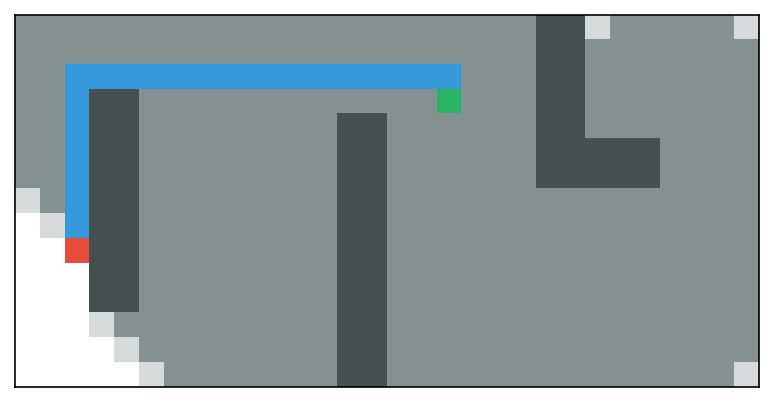

Path found! Length: 23. Search tree size: 368. Number of steps: 361. Correct: True
CPU times: user 39.7 ms, sys: 16.5 ms, total: 56.2 ms
Wall time: 805 ms


In [29]:
"""
The code should execute correctly if your Dijkstra implementation is accurate.
Experiment with the test instance number (the 2nd argument) to execute the search algorithm on various start/goal pairs.
"""
%time res = simple_test(dijkstra, 12, SearchTreeL)

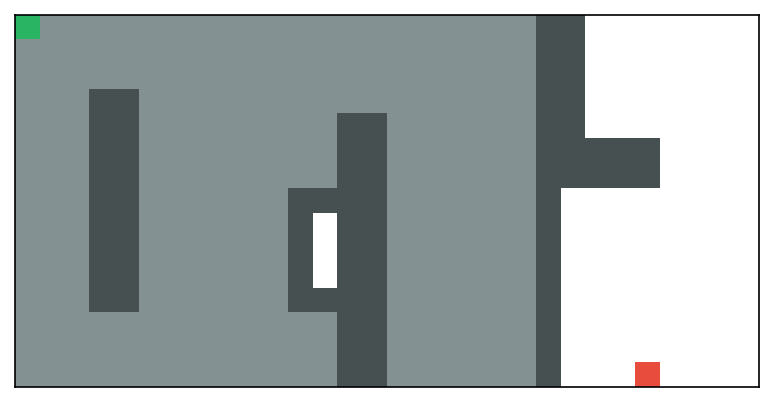

Path not found! Search tree size: 265. Number of steps: 265. Correct: True
CPU times: user 26 ms, sys: 1.86 ms, total: 27.8 ms
Wall time: 28.4 ms


In [30]:
"""
The code will execute correctly if the Dijkstra implementation properly handles cases where a path doesn't exist.
"""
%time res = simple_test_not_found(dijkstra, 0, SearchTreeL)

Now, integrate your optimized search tree implementation (`SearchTreePQD`), into Dijkstra.

You should observe an improvement in performance, indicated by a reduced runtime.

However, due to the lazy duplicate detection, the number of OPEN duplicates encountered during the search might be greater than zero. Consequently, the size of the final search tree might be larger (when compared to the list-based Dijkstra), as some duplicates might remain in OPEN at the search's final iteration.


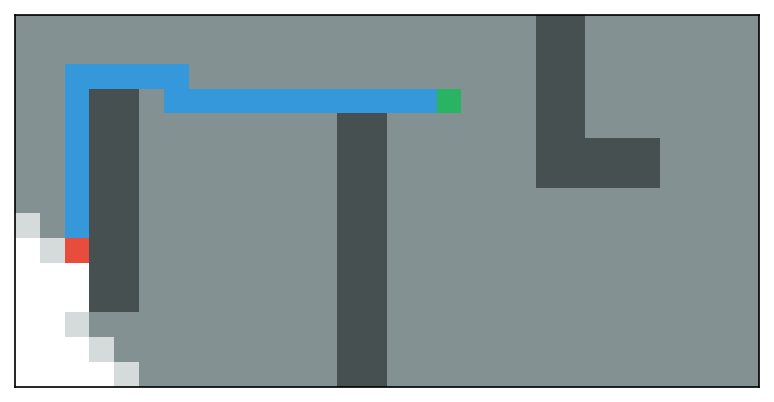

Path found! Length: 23. Search tree size: 377. Number of steps: 369. Correct: True
CPU times: user 18.3 ms, sys: 2.52 ms, total: 20.8 ms
Wall time: 38.3 ms


In [31]:
"""
The code should execute correctly if your Dijkstra implementation is accurate.
Experiment with the test instance number (the 2nd argument) to execute the search algorithm on various start/goal pairs.
"""
%time res = simple_test(dijkstra, 12, SearchTreePQD)

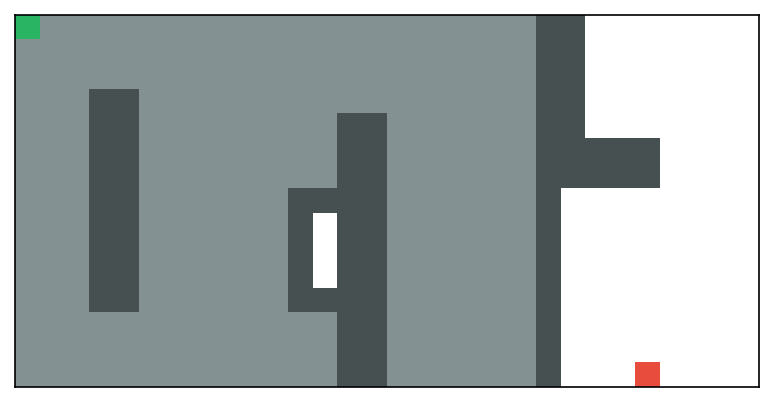

Path not found! Search tree size: 265. Number of steps: 265. Correct: True
CPU times: user 18.4 ms, sys: 2.33 ms, total: 20.7 ms
Wall time: 20.5 ms


In [32]:
"""
The code will execute correctly if the Dijkstra implementation properly handles cases where a path doesn't exist.
"""
%time res = simple_test_not_found(dijkstra, 0, SearchTreePQD)

The following cell runs the search algorithm on two larger instances.

The default (list-based) implementation of OPEN/CLOSED will be slow.

In [33]:
"""
This runs the search algorithm on two larger instances.
The default (list-based) implementation for OPEN/CLOSED will be slow.
"""
%time res = dijk_stat = massive_test(dijkstra, "data/", 2, SearchTreeL)

Task: #0. Path found! Length: 64. Search tree size: 1781. Number of steps: 1758. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 7448. Number of steps: 7447. Correct: True
CPU times: user 4.7 s, sys: 16.5 ms, total: 4.71 s
Wall time: 4.72 s


With your efficient implementation of OPEN/CLOSED solving the same large instances should take much less time.

In [34]:
"""
With your (non list-based) implementation of OPEN/CLOSED it should be much faster
"""
%time res = dijk_stat = massive_test(dijkstra, "data/", 2, SearchTreePQD)

Task: #0. Path found! Length: 64. Search tree size: 1812. Number of steps: 1757. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 7455. Number of steps: 7449. Correct: True
CPU times: user 38 ms, sys: 2.16 ms, total: 40.1 ms
Wall time: 40.2 ms


Finally, let's run your efficient implementation of Dijkstra on the full set of
large instances (9 instances in total). 

Indeed, every instance shall be solved correctly.

On my modern laptop (2022 Asus, Intel iCore7, 16Gb RAM, SSD) the entire test finishes 
in under 10 seconds.

In [35]:
"""
Lastly, test the efficient implementation of Dijkstra on the complete set of large instances (9 in total). 
Every test should execute correctly.

On my modern laptop (2022 Asus, Intel iCore7, 16Gb RAM, SSD) the entire test finishes 
in under 10 seconds.
"""
%time res = dijk_stat = massive_test(dijkstra, "data/", 9, SearchTreePQD)

Task: #0. Path found! Length: 64. Search tree size: 1812. Number of steps: 1757. Correct: True
Task: #1. Path found! Length: 197. Search tree size: 7455. Number of steps: 7449. Correct: True
Task: #2. Path found! Length: 462. Search tree size: 45911. Number of steps: 45894. Correct: True
Task: #3. Path found! Length: 498. Search tree size: 44458. Number of steps: 44433. Correct: True
Task: #4. Path found! Length: 479. Search tree size: 47545. Number of steps: 47534. Correct: True
Task: #5. Path found! Length: 402. Search tree size: 28177. Number of steps: 28173. Correct: True
Task: #6. Path found! Length: 721. Search tree size: 112605. Number of steps: 112443. Correct: True
Task: #7. Path found! Length: 678. Search tree size: 77530. Number of steps: 77410. Correct: True
Task: #8. Path found! Length: 683. Search tree size: 95903. Number of steps: 95849. Correct: True
CPU times: user 1.46 s, sys: 28.7 ms, total: 1.49 s
Wall time: 1.5 s


In [36]:
np.array(dijk_stat["st_size"]).mean(), np.array(dijk_stat["steps"]).mean()

(np.float64(51266.22222222222), np.float64(51215.77777777778))